# Identify left-right swap in brain segmentation data

Main goal: show how a varifold distance can be used to identify left-right file misnamings when segmenting brain data.

Hypotheses:
- misnamings exist
- clusters result from misnamings, i.e. a left mesh is closer (wrt varifold distance) to any other left mesh than to a right mesh


Additional goals:

- show how a varifold metric kernel can be automatically found through a decimation-based technique (i.e. the distance between a mesh and its decimated version must be very small - ideally zero) depending on a grid-search and elbow detection 

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

In [2]:
import itertools

import geomstats.backend as gs
import numpy as np
import pyvista as pv
from geomstats.varifold import VarifoldMetric
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

from polpo.preprocessing import (
    BranchingPipeline,
    EmptySkipper,
    ExceptionToWarning,
    Map,
    NestingSwapper,
    Pipeline,
    Sorter,
    Truncater,
    TupleWith,
)
from polpo.preprocessing.dict import (
    DictKeysFilter,
    DictMap,
    DictNoneRemover,
    DictUpdate,
    Hash,
)
from polpo.preprocessing.mesh.clone import TrimeshClone
from polpo.preprocessing.mesh.conversion import (
    PvFromTrimesh,
    SurfaceFromTrimesh,
    TrimeshFromData,
    TrimeshFromPv,
    TrimeshSurfaceFromTrimesh,
    TrimeshToData,
)
from polpo.preprocessing.mesh.decimation import FastSimplificationDecimator
from polpo.preprocessing.mesh.transform import MeshCenterer, MeshScaler
from polpo.preprocessing.mri import MeshExtractorFromSegmentedImage, MriImageLoader
from polpo.preprocessing.path import FileFinder, FileRule, PathShortener
from polpo.preprocessing.ssh import ScpDataLoader
from polpo.preprocessing.str import DigitFinder
from polpo.varifold import GridBasedSigmaFinder

In [3]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

Conversion pipes

In [4]:
trimesh_to_pv = Map(PvFromTrimesh(), force_iter=True)
trimesh_to_surface = Map(SurfaceFromTrimesh(), force_iter=True)
trimesh_to_trisurface = Map(TrimeshSurfaceFromTrimesh(), force_iter=True)

pv_to_data = Map([TrimeshFromPv(), TrimeshToData()])

Loading pipeline


In [5]:
folders_finder = Pipeline(
    [
        ScpDataLoader.from_host_name(
            data_dir="~/.herbrain/data/pregnancy",
            host_name="frank",
            remote_path="/home/data/pregnancy/Segmentations",
            recursive=True,
        ),
        FileFinder(),
        Sorter(),
        Truncater(value=None),
    ]
)

mri_to_mesh = ExceptionToWarning(
    [
        MriImageLoader(),
        MeshExtractorFromSegmentedImage(structure_id=-1),
        TrimeshFromData(),
    ]
)

digit_finder = Map(
    step=[
        PathShortener(),
        DigitFinder(index=0),
    ]
)

left_meshes_loader = BranchingPipeline(
    branches=[
        digit_finder,
        Map(
            step=[
                FileFinder(
                    rules=[
                        FileRule(value="left", func="startswith"),
                        FileRule(value=".nii.gz", func="endswith"),
                    ]
                ),
                EmptySkipper(step=mri_to_mesh),
            ]
        ),
    ],
    merger=[NestingSwapper(), Hash(ignore_empty=True)],
)

loading_pipe = folders_finder + left_meshes_loader

In [6]:
raw_data = loading_pipe.load()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/Segmentations').
/home/luisfpereira/Repos/github/polpo/polpo/preprocessing/path.py:82: UserWarning: Couldn't find file in: /home/luisfpereira/.herbrain/data/pregnancy/Segmentations/BB15
  warnings.warn(f"Couldn't find file in: {data_dir}")


In [7]:
meshes = list(raw_data.values())

Processing

In [8]:
processing_pipe = Map(
    [
        TrimeshClone(),
        MeshScaler(scaling_factor=20.0),
        MeshCenterer(),
    ],
    force_iter=True,
)

Find kernel params

(A simpler distance could probably have been used.)

In [9]:
decimation = (
    Map(
        step=[
            TrimeshToData(),
            FastSimplificationDecimator(target_reduction=0.99),
            TrimeshFromData(),
        ],
        force_iter=True,
    )
    + processing_pipe
)

In [10]:
template_index = 0

template_mesh = processing_pipe(meshes[template_index])
decimated_template_mesh = decimation(meshes[template_index])

In [11]:
sources = trimesh_to_trisurface([template_mesh, decimated_template_mesh])

sigma_finder = GridBasedSigmaFinder()
sigma_finder.fit(sources)

kernel = sigma_finder.kernel_builder(sigma_finder.sigma_)

sigma_finder.sigma_

/home/luisfpereira/Repos/github/geomstats/geomstats/_backend/pytorch/_common.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return _torch.from_numpy(x)


tensor(0.7075)

Compute distance matrix

In [12]:
decimate = True  # much faster

if decimate:
    surfaces = trimesh_to_trisurface(decimation(meshes))
else:
    surfaces = trimesh_to_trisurface(meshes)

surface_pairs = list(itertools.combinations(surfaces, 2))

In [13]:
kernel = sigma_finder.kernel_builder(sigma_finder.sigma_)

varifold_metric = VarifoldMetric(kernel)

In [14]:
# ~4min if not decimated
# ~5sec if decimated (0.9)
# ~2sec if decimated (0.95)
# <1sec if decimated (0.99)

sdists = [varifold_metric.squared_dist(*pair) for pair in surface_pairs]

In [15]:
indices = list(itertools.combinations(range(len(surfaces)), 2))

sdists_mat = gs.zeros((len(surfaces), len(surfaces)))

for sdist, index_pair in zip(sdists, indices):
    sdists_mat[*index_pair] = sdists_mat[*list(reversed(index_pair))] = sdist

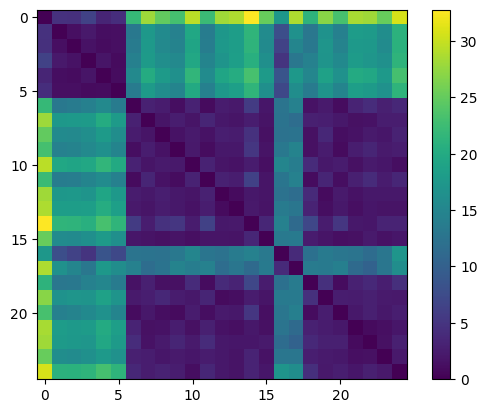

In [16]:
plt.imshow(sdists_mat)
plt.colorbar()

Find clusters

In [17]:
clusterer = AgglomerativeClustering(n_clusters=2).fit(gs.to_numpy(sdists_mat))

/home/luisfpereira/miniconda3/envs/py12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Viz

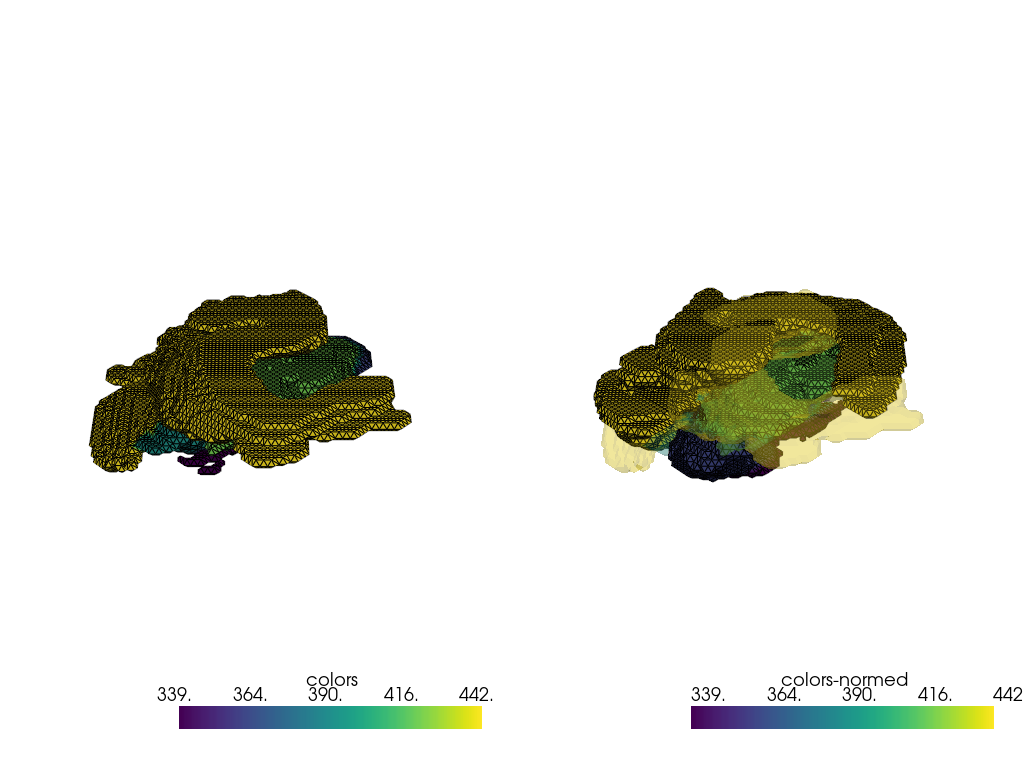

In [18]:
indices = [5, 6]


pvmeshes = trimesh_to_pv(processing_pipe([meshes[index] for index in indices]))
pl = pv.Plotter(shape=(1, 2), border=False)

pl.subplot(0, 0)
pl.add_mesh(pvmeshes[0], show_edges=True)

pl.subplot(0, 1)
pl.add_mesh(pvmeshes[1], show_edges=True)
pl.add_mesh(pvmeshes[0], opacity=0.25)

pl.link_views()

pl.show()

Load wrong meshes

In [19]:
# assumes first mesh is proper
reflected_keys = np.array(list(raw_data.keys()))[
    clusterer.labels_ != clusterer.labels_[0]
].tolist()

reflected_keys

[7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 25, 26]

In [20]:
right_meshes_loader = folders_finder + [
    TupleWith(digit_finder, incoming_first=False),
    DictKeysFilter(reflected_keys, keep=True),
    DictMap(
        [
            FileFinder(
                rules=[
                    FileRule(value="right", func="startswith"),
                    FileRule(value=".nii.gz", func="endswith"),
                ]
            ),
            mri_to_mesh,
        ]
    ),
]

In [21]:
right_meshes = right_meshes_loader.apply()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/Segmentations').
/home/luisfpereira/Repos/github/polpo/polpo/preprocessing/_preprocessing.py:39: UserWarning: File /home/luisfpereira/.herbrain/data/pregnancy/Segmentations/BB26/right_lfseg_corr_usegray_PRHC.nii.gz is not a gzip file
  warnings.warn(str(e))


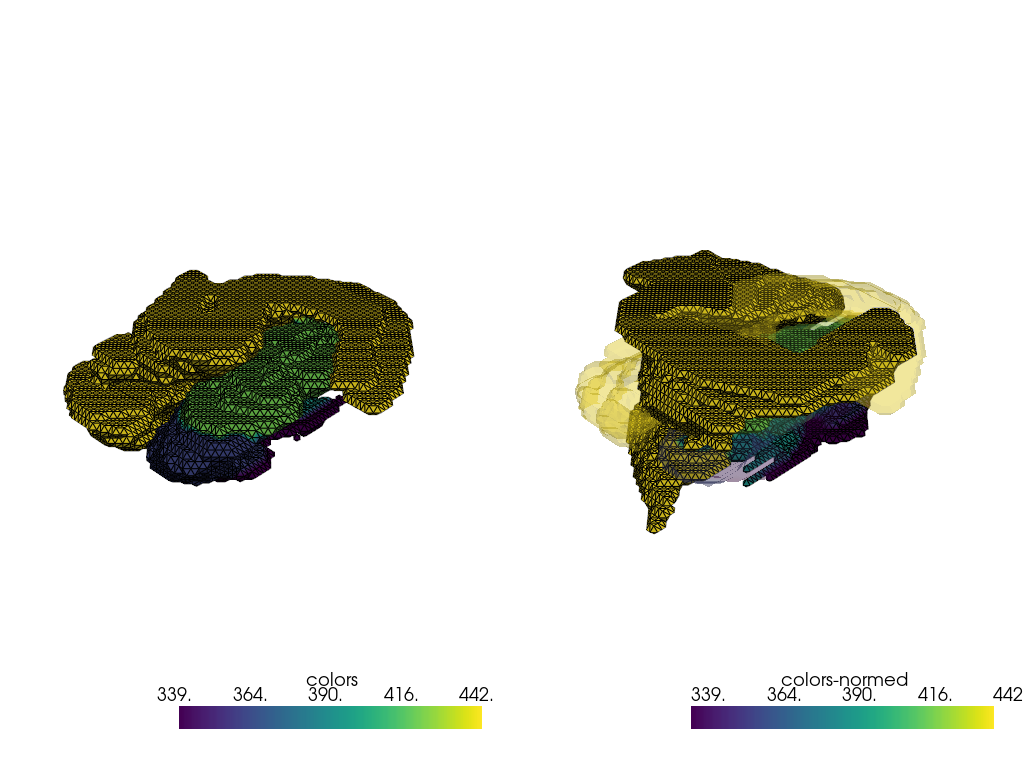

In [22]:
index = 7


pvmeshes = trimesh_to_pv(processing_pipe([raw_data[index], right_meshes[index]]))
pl = pv.Plotter(shape=(1, 2), border=False)

pl.subplot(0, 0)
pl.add_mesh(pvmeshes[0], show_edges=True)

pl.subplot(0, 1)
pl.add_mesh(pvmeshes[1], show_edges=True)
pl.add_mesh(pvmeshes[0], opacity=0.25)

pl.link_views()

pl.show()

Replace wrong meshes

In [23]:
meshes_merger = DictUpdate() + DictNoneRemover()

In [24]:
fixed_raw_data = meshes_merger([raw_data, right_meshes])

Check new distance matrix

In [25]:
fixed_meshes = list(fixed_raw_data.values())

In [26]:
if decimate:
    surfaces = trimesh_to_trisurface(decimation(fixed_meshes))
else:
    surfaces = trimesh_to_trisurface(fixed_meshes)

surface_pairs = list(itertools.combinations(surfaces, 2))

In [27]:
sdists = [varifold_metric.squared_dist(*pair) for pair in surface_pairs]

In [28]:
indices = list(itertools.combinations(range(len(surfaces)), 2))

sdists_mat = gs.zeros((len(surfaces), len(surfaces)))

for sdist, index_pair in zip(sdists, indices):
    sdists_mat[*index_pair] = sdists_mat[*list(reversed(index_pair))] = sdist

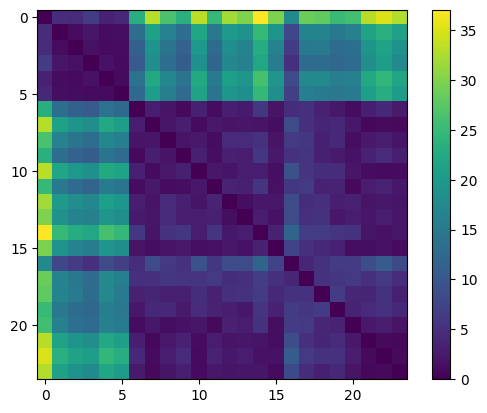

In [29]:
plt.imshow(sdists_mat)
plt.colorbar()

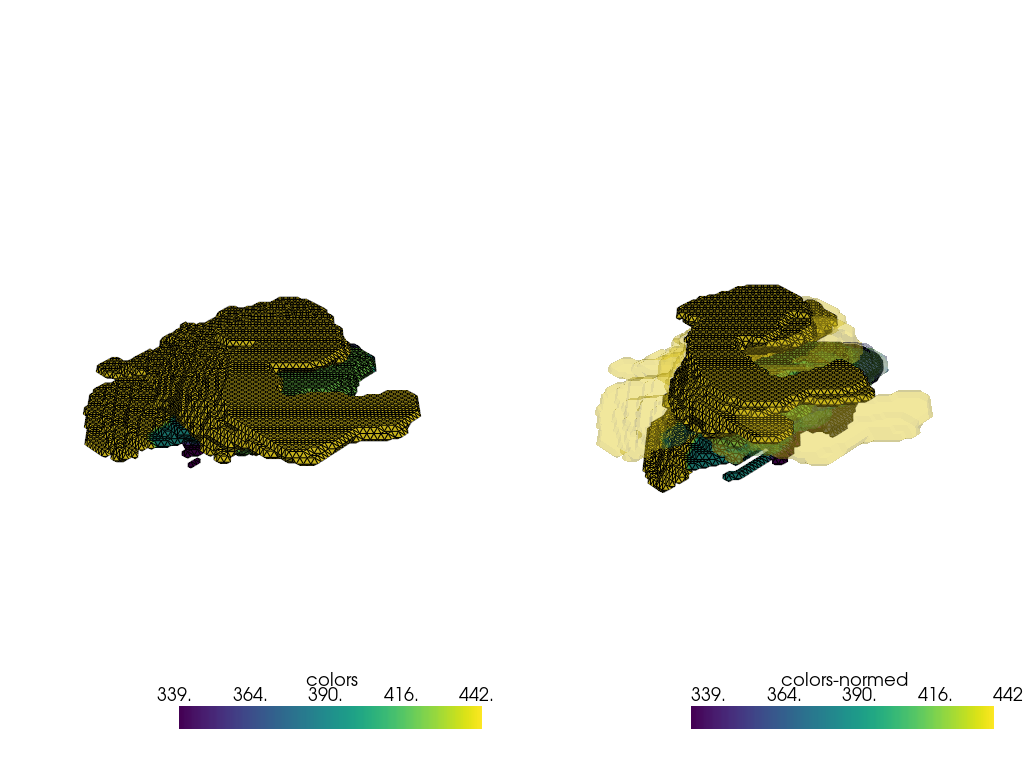

In [30]:
indices = [0, 16]


pvmeshes = trimesh_to_pv(processing_pipe([fixed_meshes[index] for index in indices]))
pl = pv.Plotter(shape=(1, 2), border=False)

pl.subplot(0, 0)
pl.add_mesh(pvmeshes[0], show_edges=True)

pl.subplot(0, 1)
pl.add_mesh(pvmeshes[1], show_edges=True)
pl.add_mesh(pvmeshes[0], opacity=0.25)

pl.link_views()

pl.show()